# Assignment 3: LDA Topic Modeling

## Note
Installing Tomotopy locally can return an error, if that's the case run this notebook on Google Colab

## Research Background

LDA is a popular topic modeling algorithm widely used in the fields of Digital Humanities and Social Sciences. In the field of political communication, topic modeling is often applied for analyzing politicians Twitter/X posts, identitying thematic patterns or topics revolving around their posts.

For this assignment, students will work with tweets from two USA politicians, Donald Trump and Bernie Sanders, who are often regarded as right-wing populist and left-wing populist respectively. Right-wing populism often emphasizes nationalism, anti-immigration policies, and a critique of global elites from a culturally conservative perspective, focusing on preserving traditional values and social hierarchies. Left-wing populism prioritizes economic inequality, advocating for the redistribution of wealth, expansion of social services, and empowerment of the working class against the capitalist elite. While both forms of populism appeal to the "common people" against perceived elites and established structures, they diverge significantly in their identification of the elites, proposed solutions, and core ideologies. For a more detailed explanation, you can read the chapter by Macaulay (2019) "Bernie and The Donald: A comparison of left-and right-wing populist discourse" (full reference below).

**Research Questions**
1. What topics are revolving around Donald Trump and Bernie Sanders' posts separately?
2. What are the topic differences between Trump (right-wing popoulist) and Sanders (left-wing populist)?

**Aim:**
1. The first aim of the assignment is to conduct LDA topic modeling. Identify thematic patterns or politics revolving around Trump or Sanders's posts.
2. The second aim is to critically evaluate the results of topic modeling. Try different numbers of topics to see with which settings the topics are more coherent. Critically reflect on the results of LDA topic modeling, discussing them in relation to existing theories about populism.

**Data**
Two datasets are prepared for this assginment. Tweets from Trump and tweets from Sanders. Students are asked to work on these two datasets.

**Methods**
1. Word segamentation
2. Removing stopwords
3. LDA topic modeling
4. Topic evaulation (coherence and human evaluation)
5. Visualization of results.

**References**
1. Macaulay, M. (2019). Bernie and the Donald: A comparison of Left-and Right-wing populist discourse. *Populist discourse: International perspectives*, 165-195.





## Setup

### Q1. Install necessary libraries, including `tomotopy` and `little_mallet_wrapper`, and import them

In [1]:
# Q1 (code)
!pip install tomotopy
!pip install little_mallet_wrapper
# Download stopwords
nltk.download('stopwords')

  Obtaining dependency information for tomotopy from https://files.pythonhosted.org/packages/bf/d3/b3797c1557b535b6b2fc5a1df5add984ea4cb69d00b883640427cb0b85b9/tomotopy-0.12.7-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.7 MB 682.7 kB/s eta 0:00:09
    --------------------------------------- 0.1/5.7 MB 1.6 MB/s eta 0:00:04
   - -------------------------------------- 0.2/5.7 MB 1.9 MB/s eta 0:00:03
   - -------------------------------------- 0.2/5.7 MB 1.9 MB/s eta 0:00:03
   - -------------------------------------- 0.2/5.7 MB 1.9 MB/s eta 0:00:03
   --- ------------------------------------ 0.5/5.7 MB 2.2 MB/s eta 0:00:03
   --- ------------------------------------ 0.5/5.7 MB 2.2 MB/s eta 0:00:03
   ---- ----------------------------------- 0.6/5.7 MB 2.3 MB/s eta 0:00:03
   ----- ---------------------------------- 0.7/5.7 MB 2.3 MB/s eta 0:00:03
   ----- -------------------------

In [10]:
import tomotopy as tp
import little_mallet_wrapper
import seaborn
import glob
from pathlib import Path
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation

## Data preprocessing

### Q2. Load the two datasets and concatenate them

The goal is to run topic modelling on the combined dataset of Sanders and Trump's tweets

In [2]:
# Q2 (code)

# Load the datasets
sanders_tweets = pd.read_csv(r'C:\Users\dudud\analysingdata\Assignment3-AD\sanders_tweets.csv')
trump_tweets = pd.read_csv(r'C:\Users\dudud\analysingdata\Assignment3-AD\trump_tweets.csv')

# Concatenate the datasets
combined_tweets = pd.concat([sanders_tweets, trump_tweets])

# Display the concatenated dataset
combined_tweets.head()

,Username,TweetId,Title,Content
0,SenSanders,1351670845639421952,SenSanders_1351670845639421952,Wealth increase in past 10 months:\n⬆️$173 bil...
1,SenSanders,1351259762722279424,SenSanders_1351259762722279424,Amidst massive income and wealth inequality te...
2,SenSanders,1351242822293319680,SenSanders_1351242822293319680,"“We now have the resources, we now have the sk..."
3,SenSanders,1350885541911400448,SenSanders_1350885541911400448,"After surviving an attempt on his life, Russia..."
4,SenSanders,1349880150041780224,SenSanders_1349880150041780224,President-Elect Biden's COVID rescue plan will...


### Q3. Clean the data

Transform all tweets to lowercase, remove stopwords, punctuation, and numbers. Add the processed text to a list called `training_data`.
Create a list with the content of the tweets (`original_texts`) and a list that allows you to identify both the author of the tweet and its ID (`titles`).


In [21]:
# Q3 (code)

# Function to clean tweet text without using other libraries for punctuation and numbers removal
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs, user mentions, and other specific patterns
    text = re.sub(r"http\S+|www\S+|https\S+|\/\/t|co\/|\@\w+|realdonaldtrump", '', text, flags=re.MULTILINE)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', punctuation))
    # Remove numbers
    text = ''.join(char for char in text if not char.isdigit())
    # Tokenize text
    tokens = word_tokenize(text)
    # Manually add additional stopwords that I found in experiment
    additional_stopwords = {'amp', 'rt', '’', '“', '”', '‘'}
    # Combine the existing stopwords with the additional stopwords
    stop_words = set(stopwords.words('english')).union(additional_stopwords)
    # Remove stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into string
    cleaned_text = ' '.join(filtered_tokens)
    return cleaned_text

# Apply cleaning function to tweets
combined_tweets['processed_text'] = combined_tweets['Content'].apply(clean_text)

# Create lists
training_data = combined_tweets['processed_text'].tolist()
original_texts = combined_tweets['Content'].tolist()
titles = [(author, tweet_id) for author, tweet_id in zip(combined_tweets['Username'], combined_tweets['TweetId'])]

# Display the first few items in each list
print("Training Data (processed_text):", training_data[:5])
print("\nOriginal Texts:", original_texts[:5])
print("\nTitles:", titles[:5])


# Tip: add the following line to remove URLS and user mentions
# processed_text = re.sub(r"http\S+|www\S+|https\S+|\/\/t|co\/|\@\w+|realdonaldtrump", '', processed_text, flags=re.MULTILINE)

Training Data (processed_text): ['wealth increase past months ⬆️ billion elon musk ⬆️ billion jeff bezos ⬆️ billion walton family ⬆️ billion bill gates ⬆️ billion mark zuckerberg year increase us minimum wage must tax rich raise minimum wage least', 'amidst massive income wealth inequality tens millions americans working starvation wages need raise minimum wage living wage least hour excuses need act', 'resources skills techniques get rid poverty question whether nation — dr martin luther king jr', 'surviving attempt life russian activist alexei navalny detained bravely returning russia today call release united states must stand fighting corruption working democracy around world', 'presidentelect bidens covid rescue plan begin provide people muchneeded support direct payments minimum wage look forward working colleagues congress urgently provide bold relief working families']

Original Texts: ['Wealth increase in past 10 months:\n⬆️$173 billion: Elon Musk\n⬆️$77 billion: Jeff Bezos\n⬆

## LDA topic modelling

### Q4. Train a an LDA topic model with `tomotopy`

In [54]:
# Q4 (code)

# Number of topics to return
num_topics = 16
# Numer of topic words to print out
num_topic_words = 10

# Intialize the model
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')


Topic Model Training...


Iteration: 0	Log-likelihood: -9.407967714313623
Iteration: 10	Log-likelihood: -8.999718209739
Iteration: 20	Log-likelihood: -8.812021327637066
Iteration: 30	Log-likelihood: -8.707007716560954
Iteration: 40	Log-likelihood: -8.637364421858507
Iteration: 50	Log-likelihood: -8.58475988083721
Iteration: 60	Log-likelihood: -8.544596391101967
Iteration: 70	Log-likelihood: -8.51302431749644
Iteration: 80	Log-likelihood: -8.491988049203929
Iteration: 90	Log-likelihood: -8.476747154983132


### Q5. Print out the top words for each topic and manually evaluate their coherence


In [56]:
# Q5a (code)

# Print out top 10 words for each topic
print("\nTopic Model Results:\n\n")

topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")


Topic Model Results:


✨Topic 0✨

thank great state see big florida people carolina maga hurricane

✨Topic 1✨

news fake media people like would even never much good

✨Topic 2✨

election trump vote biden votes voting voter ballots fraud state

✨Topic 3✨

biden republican senate joe party vote trump house pelosi president

✨Topic 4✨

great president house white today thank meeting conference minister prime

✨Topic 5✨

people drug money street wall big american prices americans companies

✨Topic 6✨

president trump economy years jobs history ever since year record

✨Topic 7✨

president court trump supreme live tonight pm watch justice today

✨Topic 8✨

china us trade states united deal many countries great years

✨Topic 9✨

great thank america women american today country nation honor make

✨Topic 10✨

health care people tax workers americans must million need right

✨Topic 11✨

great total endorsement vote complete strong military state amendment vets

✨Topic 12✨

us war trump people u

# Q5b (words)
# Describe what each topic is about. What ideas, values, or situations do these keywords refer to?


Topic 0: Gratitude and acknowledgment, mentioning "thank", "great", and appreciation for support, particularly related to states and events like hurricanes.

Topic 1: Critique of the media, discussing "fake news", skepticism towards media sources, and perceptions of biased reporting.

Topic 2: Political elections and voting, addressing topics like election fraud, voter ballots, and concerns related to the integrity of the electoral process.

Topic 3: Political dynamics, mentioning Joe Biden, the Republican Party, voting behaviors, and key political figures like Trump and Pelosi.

Topic 4: Presidential activities and events, including mentions of meetings, conferences, and events at the White House with various ministers and officials.

Topic 5: Economic issues, focusing on discussions about drug prices, Wall Street, and the financial interests of Americans.

Topic 6: Economic prosperity and job creation, emphasizing the strength of the economy and job growth during certain periods.

Topic 7: Legal and judicial matters, mentioning the Supreme Court, presidential actions, and calls to watch live judicial proceedings.

Topic 8: International trade relations, discussing trade deals with China, the United States, and other countries.

Topic 9: Celebrations and acknowledgments of national events and achievements, honoring America, women, and the nation's progress.

Topic 10: Healthcare and social welfare, addressing the importance of healthcare, taxation, workers' rights, and the well-being of Americans.

Topic 11: Appreciation for support, including endorsements, votes, and appreciation for military veterans.

Topic 12: Discussions about war, mentioning conflicts with Iran, the United States' involvement, and the need for unity among Americans.

Topic 13: Political conflicts and investigations, involving Democrats, impeachment, FBI investigations, and allegations of collusion.

Topic 14: Environmental concerns and public health, discussing climate change, energy policies, the fossil fuel crisis, and responses to the coronavirus pandemic.

Topic 15: Political discourse, discussing Democrats, border security, and the desire for change in the country's security measures.

## Topic coherence

Use `tomotopy`'s [`.coherence()`](https://bab2min.github.io/tomotopy/v0.10.0/en/coherence.html) function to automatically calculate the topic coherence.

The coherence value can vary from `0` (no coherence) to `1` (maximum coherence). Interpret the results and, if needed, retrain the model using a different number of topics.

In [55]:
# There are different metrics for coherence, we choose `c_v`

coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.5947718534618616 
Per Topic: [0.5582876294851303, 0.5679220780730247, 0.6574939951300621, 0.5521265715360641, 0.6193997025489807, 0.5587185025215149, 0.5322122365236283, 0.5122104793787002, 0.5824872940778733, 0.5257816046476365, 0.6536803632974625, 0.7855539143085479, 0.48638784885406494, 0.7121263176202774, 0.6925089806318283, 0.5194521367549896]



### Q6. Interpret topic coherence

Report the following:
- number of topics you initially used to train the model and the coherence score you got
- changes made to the number of topics and new coherence scores obtained

# Q6 (words)

I inintally used five topics to train the model and this is the coherence score:
Average: 0.4905071099102497 
Per Topic: [0.5123364008963108, 0.5853019148111344, 0.46858508586883546, 0.48147147595882417, 0.4048406720161438]

In this new model of 16 topics, the average coherence score is 0.595, which suggests moderate to good coherence among the topics. Some topics have higher coherence values than others. Topics 11, 13, and 14 stand out with relatively high coherence scores, indicating that they are more coherent and interpretable compared to other topics.

### X1. Optional question 1
(This question is not compulsory, it only allows you to get an extra point.)

Create a function to plot the average coherence for models with different number of topics.

In [ ]:
# X1 (code)
# Tip: y = average topic coherence; x = number of topics in the model


### Q7. Topic distributions
Calculate the topic distributions for all tweets and get the top documents for some topics (between 2 and 5) that you think could be more representative of Sanders or Trump.

In [68]:
# Q7a (code)
from IPython.display import Markdown, display

# Get topic distributions for all tweets
topic_distributions = [list(doc.get_topic_dist()) for doc in model.docs]
# Function to get the top documents for a given topic
def make_md(string):
    display(Markdown(str(string)))

def get_top_docs(docs, topic_distributions, topic_index, n=5):

    sorted_data = sorted([(_distribution[topic_index], _document)
                          for _distribution, _document
                          in zip(topic_distributions, docs)], reverse=True)

    topic_words = topics[topic_index]

    make_md(f"### ✨Topic {topic_index}✨\n\n{topic_words}\n\n")
    print("---")

    for probability, doc in sorted_data[:n]:
        # Make topic words bolded
        for word in topic_words.split():
            if word in doc:
                doc = re.sub(f"\\b{word}\\b", f"**{word}**", doc, re.IGNORECASE)

        make_md(f'✨  \n**Topic Probability**: {probability}  \n**Document**: {doc}\n\n')

    return

# Get top documents for each topic (selecting topic 13 that could be more representative of Trump and topic 14 for Sanders)
get_top_docs(titles, topic_distributions, topic_index=13, n=10)
get_top_docs(titles, topic_distributions, topic_index=14, n=10)


### ✨Topic 13✨

democrats impeachment trump president fbi russia collusion witch hunt mueller



---


✨  
**Topic Probability**: 0.938915491104126  
**Document**: ('@realDonaldTrump', 944667102312566784)



✨  
**Topic Probability**: 0.9366404414176941  
**Document**: ('@realDonaldTrump', 1020316352140185600)



✨  
**Topic Probability**: 0.9315409064292908  
**Document**: ('@realDonaldTrump', 974069957905428481)



✨  
**Topic Probability**: 0.9286704063415527  
**Document**: ('@realDonaldTrump', 1064540462848098304)



✨  
**Topic Probability**: 0.9286704063415527  
**Document**: ('@realDonaldTrump', 1028633682918166528)



✨  
**Topic Probability**: 0.9255486130714417  
**Document**: ('@realDonaldTrump', 1026474458326986752)



✨  
**Topic Probability**: 0.9142960906028748  
**Document**: ('@realDonaldTrump', 1171733174101131264)



✨  
**Topic Probability**: 0.9097492694854736  
**Document**: ('@realDonaldTrump', 1199185681702178816)



✨  
**Topic Probability**: 0.9097492694854736  
**Document**: ('@realDonaldTrump', 1093201175455911939)



✨  
**Topic Probability**: 0.909506618976593  
**Document**: ('@realDonaldTrump', 1125933907923353600)



### ✨Topic 14✨

climate must change energy fossil crisis coronavirus planet federal need



---


✨  
**Topic Probability**: 0.9619848132133484  
**Document**: ('SenSanders', 1214612324599898112)



✨  
**Topic Probability**: 0.9619848132133484  
**Document**: ('SenSanders', 1152332004232486912)



✨  
**Topic Probability**: 0.9602895975112915  
**Document**: ('SenSanders', 1292942399585619968)



✨  
**Topic Probability**: 0.9602895975112915  
**Document**: ('SenSanders', 1189925450774126592)



✨  
**Topic Probability**: 0.9593839645385742  
**Document**: ('SenSanders', 1157625026524241920)



✨  
**Topic Probability**: 0.9574429392814636  
**Document**: ('SenSanders', 1245514542915956736)



✨  
**Topic Probability**: 0.9574429392814636  
**Document**: ('SenSanders', 1138838564962263040)



✨  
**Topic Probability**: 0.9440807700157166  
**Document**: ('SenSanders', 1143668877169168384)



✨  
**Topic Probability**: 0.9422681331634521  
**Document**: ('SenSanders', 1154806673296506880)



✨  
**Topic Probability**: 0.9379926323890686  
**Document**: ('SenSanders', 1318297194429091840)



Interpret the results above. Are there topics that have top tweets only by one politician? Why do you think these topics are more representative of one of the two politicians' views?

# Q7b (words)
For both these topics I chose, the top tweets are exclusively from one politician. 

Topic 13: Top tweets are all from Trump. The keywords in this topic, such as "democrats", "impeachment", "FBI", "Russia collusion", align with Trump's narrative about his presidency regarding the impeachment inquiry and allegations of collusion against himself.

Topic 14: Top tweets are all from Sanders. The keywords in this topic, including "climate change", "energy", "fossil crisis", resonate with Sanders' emphasis on progressive policies such as environmental protection and the need for action to combat climate change.


## Large scale analysis

### Q8. Create a random sample of the whole dataset and visualize the topic distributions for the sampled tweets

In [71]:
# Crete a sample of tweets

from random import sample

target_labels = sample(titles,100)

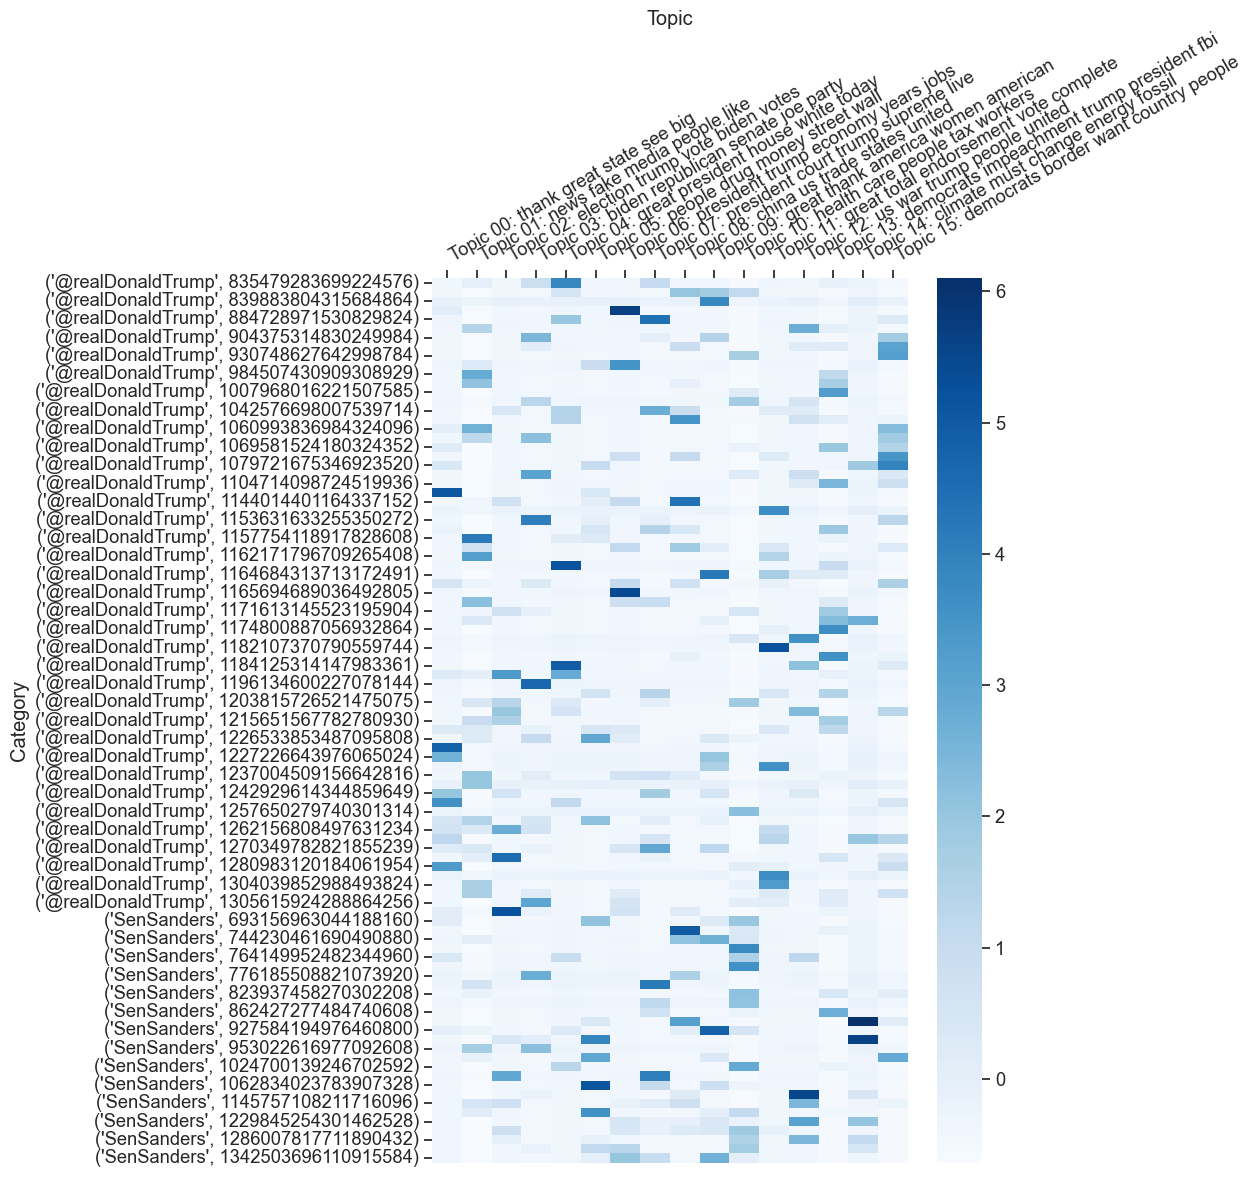

In [75]:
# Q8 (code)
# Create a heatmap using the random sample
# Tip: to display more than 20 tweets you have to change the values of `dim =` in sns.heatmap()
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='ticks', font_scale=1.2)
def plot_categories_by_topics_heatmap(labels,
                                      topic_distributions,
                                      topic_keys,
                                      output_path=None,
                                      target_labels=None,
                                      color_map = sns.cm.rocket_r,
                                      dim=None):

    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution):
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category',
                                     columns='Topic',
                                     values='Probability')
    df_norm_col=(df_wide-df_wide.mean())/df_wide.std()

    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_col, cmap=color_map)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    plt.show()

plot_categories_by_topics_heatmap(titles,
                                  topic_distributions,
                                  topic_individual_words,
                                  target_labels=target_labels,
                                  color_map = 'Blues',
                                 dim=(12,12))

### Q9. Interpret the heatmap
Do you see any pattern in the probability distributions of topics for each politician?

Are there topics that are more likely for one of the two politicians?

# Q9 (words)

Darker shades indicate a higher probability that the tweet corresponds to the topic for that politician. Lighter shades indicate a lower probability.

From this random sample, topics 00 (state mentions and MAGA) and 06 (economic achievements and jobs) are more likely for Trump. Topics 10 (healthcare and worker rights) and 14 (climate change and energy policy) are more likely for Sanders.

Trump's tweets appear to show a higher probability for topics related to media criticism, economic performance, foreign trade, and immigration. On the other hand, Sanders seems to focus more on systemic issues like healthcare, workers' rights, climate change, and international conflict.

### X2. Optional question 2
(This question is not compulsory, it only allows you to get an extra point)

Make the sample balanced, with 50 tweets by Trump and 50 by Sanders.

In [78]:
# X2 (code)

# Filter out the titles for each politician
sanders_titles = [title for title in titles if title[0] == 'SenSanders']
trump_titles = [title for title in titles if title[0] == '@realDonaldTrump']
# Sample 50 titles from each politician
balanced_sample = sample(sanders_titles, 50) + sample(trump_titles, 50)


### X3. Optional question 3
(This question is not compulsory, it only allows you to get an extra point)

Extend the analysis to all the tweets in the dataset.

In [ ]:
# X3 (code and words)
# Tip: plotting a heatmap for thousands of tweets is not practical.
# Make a comparison based on the numerical values in the `df_norm_col` dataframe (see Week 6 notebook)